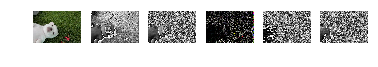

In [1]:
from matplotlib import gridspec as gridspec
from matplotlib import pyplot as plt
import tensorflow as tf
import kernels

FILENAME = '/home/rosa/사진/dog.jpeg'

#텐서플로우에서 어떻게 이미지를 오픈시키는 지에 대한 함수
def read_one_image(filename):
    filename_queue = tf.train.string_input_producer([filename]) #읽을 파일목록을 filename_queue에 저장
    #print(filename_queue) #<tensorflow.python.ops.data_flow_ops.FIFOQueue object at 0x7f853199fa20
    
    image_reader = tf.WholeFileReader() #reader가 filename queue에서 파일명 하나씩 읽어옴
    #print(image_reader) #<tensorflow.python.ops.io_ops.WholeFileReader object at 0x7f85044d3438>
    
    _, image_file = image_reader.read(filename_queue)
    image = tf.image.decode_jpeg(image_file, channels=3) 
    #Tensor("DecodeJpeg_14:0", shape=(?, ?, 3), dtype=uint8
    #print(image)#decoder에서 해당 파일을 열어서 데이터를 읽는다.
    
    image = tf.cast(image, tf.float32) / 256.0  
    #Tensor("truediv_14:0", shape=(?, ?, 3), dtype=float32)
    # cast to float to make conv2d work #읽어들인 데이터를 텐서플로우모델에 맞게 정재한다.
    #print(image)
    
    return image

#필터함수_con&relu
def convolve(image, kernels, rgb=True, strides=[1, 3, 3, 1], padding='SAME'):
    images = [image[0]]
    for i, kernel in enumerate(kernels):
        filtered_image = tf.nn.conv2d(image, kernel, strides=strides, padding=padding)[0]
        if i == 2:
            filtered_image = tf.minimum(tf.nn.relu(filtered_image), 255)
        images.append(filtered_image)
    return images

#session을 run시키는 함수
def get_real_images(images):
    with tf.Session() as sess:
        coord = tf.train.Coordinator()
        #print(coord) #<tensorflow.python.training.coordinator.Coordinator object at 0x7f84f6e76da0>
        threads = tf.train.start_queue_runners(coord=coord)
        #print(threads)
        images = sess.run(images)
        coord.request_stop()
        coord.join(threads)
    return images

#image를 보여주는 함수
def show_images(images, rgb=True):
    gs = gridspec.GridSpec(1, len(images))
    for i, image in enumerate(images):
        plt.subplot(gs[0, i])
        if rgb:
            plt.imshow(image)
        else: 
            image = image.reshape(image.shape[0], image.shape[1])
            plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

def main():
    rgb = True
    if rgb:
        kernels_list = [kernels.BLUR_FILTER_RGB, kernels.SHARPEN_FILTER_RGB, kernels.EDGE_FILTER_RGB, 
                    kernels.TOP_SOBEL_RGB, kernels.EMBOSS_FILTER_RGB]
        #print(kernels_list)#아무것도 안나옴
    else:
        kernels_list = [kernels.BLUR_FILTER, kernels.SHARPEN_FILTER, kernels.EDGE_FILTER, 
                    kernels.TOP_SOBEL, kernels.EMBOSS_FILTER]
        #print(kernels_list) 
        #[<tf.Tensor 'Const_1:0' shape=(3, 3, 1, 1) dtype=float32>, <tf.Tensor 'Const_3:0' shape=(3, 3, 1, 1) dtype=float32>, <tf.Tensor 'Const_5:0' shape=(3, 3, 1, 1) dtype=float32>, <tf.Tensor 'Const_7:0' shape=(3, 3, 1, 1) dtype=float32>, <tf.Tensor 'Const_9:0' shape=(3, 3, 1, 1) dtype=float32>]


    image = read_one_image(FILENAME)
    #print(image)
    #Tensor("truediv_3:0", shape=(?, ?, 3), dtype=float32)
    if not rgb:
        image = tf.image.rgb_to_grayscale(image)
        #print(image)
        #Tensor("rgb_to_grayscale_4:0", shape=(?, ?, 1), dtype=float32)
    image = tf.expand_dims(image, 0) # to make it into a batch of 1 element
    #print(image) 
    #Tensor("ExpandDims_5:0", shape=(1, ?, ?, 1), dtype=float32)

    images = convolve(image, kernels_list, rgb)
    #print(images)
    #[<tf.Tensor 'strided_slice_36:0' shape=(?, ?, 1) dtype=float32>, <tf.Tensor 'strided_slice_37:0' shape=(?, ?, 1) dtype=float32>, <tf.Tensor 'strided_slice_38:0' shape=(?, ?, 1) dtype=float32>, <tf.Tensor 'Minimum_6:0' shape=(?, ?, 1) dtype=float32>, <tf.Tensor 'strided_slice_40:0' shape=(?, ?, 1) dtype=float32>, <tf.Tensor 'strided_slice_41:0' shape=(?, ?, 1) dtype=float32>]
    images = get_real_images(images)
    #print(images)
    show_images(images, rgb)

if __name__ == '__main__':
    main()